In [16]:
ubc_data_path = '../ubc_data_relevant_splitted'
ubc_input_path = f'{ubc_data_path}/input'
target_path = f'{ubc_data_path}/target'

In [17]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import os
import sys

# Below paths: bad but managable

# for our_lib
module_path = os.path.abspath(os.path.join('./our_lib')) # or the path to your source code
print(module_path)
sys.path.append(module_path)

# for recsys2025
# module_path = os.path.abspath(os.path.dirname(os.path.abspath(__file__)).join('../../.'))
module_path = os.path.abspath(os.path.join('../.')) # or the path to your source code
sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../recsys2025')) # or the path to your source code
sys.path.append(module_path)


# from our_lib import *
from our_lib import RecSysData
# from our_lib import split_data, create_baseline_embeddings, contest_training
# from our_lib import validate_and_load_embeddings  
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/zmrocze/studia/uwr/sem2/adm/projekt/src/our_lib


# load data

In [18]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [19]:
# load everything
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import torchmetrics as tm

In [20]:
from src.our_lib import RecSysData, unique_edges, load_target, drop_duplicates, all_categories_in_df_numpy, all_users_in_df_numpy, all_items_in_df_numpy, join_item_with_category

input_data = RecSysData.read_parquet(ubc_input_path)
product_properties = pd.read_parquet(f'{ubc_data_path}/product_properties.parquet')
all_input_users = input_data.all_users_set()
all_categories = all_categories_in_df_numpy(product_properties)
input_data

RecSysData(
  add_to_cart=1922253,
  page_visit=32941261,
  product_buy=939835,
  product_properties=1197634,
  remove_from_cart=800359,
  search_query=3204721,
  all users: 858489,
  all products: 674374
  all urls: 5185400,
)

In [21]:
ls

artifacts/          main.ipynb        recsys2025_local.ipynb
baseline_emb.ipynb  more_stats.ipynb  recsys2025_sat.ipynb
basic_stats.ipynb   notes.md          recsys2025_sat_local.ipynb
embeds/             our_lib/          recsys2025_wyniki.ipynb
gat.ipynb           recsys2025/       train_test_split_stats.ipynb
lightning_logs/     recsys2025.ipynb  wandb/


In [22]:
client_ids = np.load('./embeds/client_ids.npy')
embeddings = np.load('./embeds/embeddings.npy')

In [28]:
client_ids.shape

(21233,)

In [29]:
baseline_client_ids = np.load("../baseline_embeddings_relevant/client_ids.npy")
baseline_embeddings = np.load("../baseline_embeddings_relevant/embeddings.npy") 
print(baseline_client_ids.shape, baseline_embeddings.shape, len(set(client_ids).intersection(set(baseline_client_ids))) == 21233)

(858489,) (858489, 320) True


In [40]:
baseline_embeddings_dict = dict(zip([int(id) for id in baseline_client_ids], baseline_embeddings))
# baseline_embeddings_dict

In [38]:
int(baseline_client_ids[0])

14

In [ ]:
# baseline_embeddings_dict = dict(zip([int(id) for id in baseline_client_ids], baseline_embeddings))

joint_embeddings = []
for client, embed in zip(client_ids, embeddings):
  joint_embed = np.concat((baseline_embeddings_dict[client], embed), axis=0)
  joint_embeddings.append(joint_embed)

# joint_embeddings = np.array(joint_embeddings, dtype=np.float16)

# np.save('./joint_embeds/client_ids.npy', client_ids)
# np.save('./joint_embeds/embeddings.npy', joint_embeddings)

In [45]:
joint_embeddings = np.array(joint_embeddings, dtype=np.float16)

In [47]:
joint_embeddings.shape

(21233, 384)

In [48]:
! mkdir joint_embeds

In [49]:
np.save('./joint_embeds/client_ids.npy', client_ids)
np.save('./joint_embeds/embeddings.npy', joint_embeddings)

In [8]:
delattr(input_data, 'page_visit')
delattr(input_data, 'search_query')

In [9]:
target_path = "../ubc_data_relevant_splitted/target"
target_data = load_target(target_path)
train_target = target_data['train_target']
valid_target = target_data['validation_target']

In [10]:
input_data.add_to_cart = join_item_with_category(input_data.add_to_cart, product_properties)
input_data.remove_from_cart = join_item_with_category(input_data.remove_from_cart, product_properties)
input_data.product_buy = join_item_with_category(input_data.product_buy, product_properties)

In [9]:
first_train_timestamp = train_target['timestamp'].min()
first_valid_timestamp = valid_target['timestamp'].min()

print(f"First timestamp in train_target: {first_train_timestamp}")
print(f"First timestamp in valid_target: {first_valid_timestamp}")

First timestamp in train_target: 2022-09-13 00:03:35
First timestamp in valid_target: 2022-09-27 00:00:15


In [10]:
print(input_data.add_to_cart['timestamp'].min())
print(input_data.remove_from_cart['timestamp'].min())
print(input_data.product_buy['timestamp'].min())
print(input_data.add_to_cart['timestamp'].max())
print(input_data.remove_from_cart['timestamp'].max())
print(input_data.product_buy['timestamp'].max())

2022-05-23 00:10:15
2022-05-23 00:12:20
2022-05-23 00:10:40
2022-09-12 23:59:45
2022-09-12 23:58:10
2022-09-12 23:58:35


In [11]:
# drop duplicates
aaxxrta = 'category' # 'sku'
drop_duplicates(input_data.add_to_cart, subset=['client_id', aaxxrta])
drop_duplicates(input_data.remove_from_cart, subset=['client_id', aaxxrta])
drop_duplicates(input_data.product_buy, subset=['client_id', aaxxrta])

drop_duplicates(train_target, subset=['client_id', aaxxrta])
drop_duplicates(valid_target, subset=['client_id', aaxxrta])

# print all the lengths
print(f"add_to_cart: {len(input_data.add_to_cart)}")
print(f"remove_from_cart: {len(input_data.remove_from_cart)}")
print(f"product_buy: {len(input_data.product_buy)}")
print(f"train_target: {len(train_target)}")
print(f"valid_target: {len(valid_target)}")

print(f"len(users) x len(categories): {len(all_input_users) * len(all_categories)}")

add_to_cart: 1922253
remove_from_cart: 800359
product_buy: 939835
train_target: 130109
valid_target: 148479
len(users) x len(categories): 5480593776


In [12]:
# input_data.print_datasets_stats_nicely("input data")

In [12]:
train_users_set = set(train_target['client_id'].unique())
valid_users_set = set(valid_target['client_id'].unique())

In [14]:
# Get users who have only one interaction across all input data types
all_interactions = pd.concat([
  input_data.add_to_cart[['client_id']],
  input_data.remove_from_cart[['client_id']],
  input_data.product_buy[['client_id']]
])

user_interaction_counts = all_interactions['client_id'].value_counts()
single_interaction_users = set(user_interaction_counts[user_interaction_counts == 1].index)
users_not_in_test = single_interaction_users.difference(valid_users_set).difference(train_users_set)

print(f"Users with single interaction in input_data: {len(single_interaction_users)}")
print(f"Users with single interaction and no interaction in test set: {len(users_not_in_test)}")

Users with single interaction in input_data: 190183
Users with single interaction and no interaction in test set: 181914


In [15]:
# removing these, no information gained
input_data.add_to_cart = input_data.add_to_cart[~input_data.add_to_cart['client_id'].isin(users_not_in_test)]
input_data.remove_from_cart = input_data.remove_from_cart[~input_data.remove_from_cart['client_id'].isin(users_not_in_test)]
input_data.product_buy = input_data.product_buy[~input_data.product_buy['client_id'].isin(users_not_in_test)]

In [16]:
# sanity check
_known_categories = set(input_data.add_to_cart['category'].unique()).union(
    set(input_data.remove_from_cart['category'].unique())).union(
    set(input_data.product_buy['category'].unique()))
known_users = set(input_data.add_to_cart['client_id'].unique()).union(
    set(input_data.remove_from_cart['client_id'].unique())).union(
    set(input_data.product_buy['client_id'].unique()))

len(_known_categories), len(known_users), len(all_categories)

(6130, 485297, 6384)

In [17]:
train_target_known = train_target[train_target['client_id'].isin(known_users)]
valid_target_known = valid_target[valid_target['client_id'].isin(known_users)]
print(f"train_target_known: {len(train_target_known)}")
print(f"valid_target_known: {len(valid_target_known)}")

train_target_known: 60108
valid_target_known: 63112


# training gat

In [11]:
# imports
# from src.our_lib import NodeIdMap, JustGAT, RecGAT, DotproductEdgePredictor, LinearEdgePredictor, BprLossLoader
# from src.our_lib import test_out, l2_reg, train_test_split_pos_edges, int_tensor, unique_edges
from src.our_lib import NodeIdMap, JustGAT, RecGAT, DotproductEdgePredictor, LinearEdgePredictor, BprLossLoader, test_out, l2_reg, train_test_split_pos_edges, int_tensor, unique_edges, loss_f, BprTraining
import random

In [12]:
chk_path = '/home/zmrocze/studia/uwr/sem2/adm/projekt/src/artifacts/model-cxmw40yd:v1'
checkpoint = torch.load(f"{chk_path}/model.ckpt", map_location=torch.device('cpu'), weights_only=False)

In [13]:
# print(checkpoint['my_node_id_map'])
my_node_id_map = checkpoint['my_node_id_map']
my_user_emb = checkpoint['my_user_emb']
print("my_node_id_map:", my_node_id_map)
print("my_user_emb:", my_user_emb)

my_node_id_map: <gat.NodeIdMap object at 0x7fdc3d8e9a30>
my_user_emb: tensor([[ 0.0611,  0.0621,  0.0112,  ...,  0.1038, -0.0331,  0.0427],
        [ 0.0611,  0.0621,  0.0112,  ...,  0.1038, -0.0331,  0.0427],
        [ 0.0611,  0.0621,  0.0112,  ...,  0.1038, -0.0331,  0.0427],
        ...,
        [ 0.0611,  0.0621,  0.0112,  ...,  0.1038, -0.0331,  0.0427],
        [ 0.0611,  0.0621,  0.0112,  ...,  0.1038, -0.0331,  0.0427],
        [ 0.0611,  0.0621,  0.0112,  ...,  0.1038, -0.0331,  0.0427]])


In [50]:
chkpt_path = "zmrocze-uniwroc/recsys2025_lightgcn/model-4f6vvgpe:v0"

In [51]:
import wandb
run = wandb.init()

wandb: Currently logged in as: zmrocze (zmrocze-uniwroc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [85]:
# chkpt_path = "zmrocze-uniwroc/recsys2025_lightgcn/model-4f6vvgpe:v0"
chkpt_path = "zmrocze-uniwroc/recsys2025_lightgcn/model-8h3rba3z:v0"

In [86]:
# prompt: load model from a weights&biases checkpoint
# import wandb

# Define the run ID from W&B
wb_path = chkpt_path

import torch

artifact = run.use_artifact(wb_path, type='model')
# artifact = wandb.use_artifact(wb_path, type='model')
artifact_dir = artifact.download()

# Load the model checkpoint
checkpoint = torch.load(f"{artifact_dir}/model.ckpt", map_location=torch.device('cpu'), weights_only=False)

print(checkpoint)

wandb:   1 of 1 files downloaded.  


{'epoch': 8, 'global_step': 315, 'pytorch-lightning_version': '2.5.2', 'state_dict': OrderedDict({'recgat.gat.alpha': tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]), 'recgat.gat.embedding.weight': tensor([[ 1.1719e-03,  1.7234e-04, -5.2348e-05,  ...,  2.9890e-04,
          2.2884e-04, -5.6187e-04],
        [ 5.0503e-05,  1.1805e-04, -1.1455e-05,  ...,  6.5362e-05,
          1.9911e-05, -2.7159e-05],
        [-1.1954e-03, -2.0915e-03, -7.4376e-04,  ..., -1.8389e-03,
         -7.1728e-04,  1.9671e-04],
        ...,
        [-2.3420e-07, -3.7207e-06, -6.0852e-05,  ..., -3.3381e-10,
          2.5765e-10,  1.5149e-08],
        [-5.5120e-05, -2.1299e-04, -1.0227e-04,  ...,  2.6402e-04,
          2.9742e-05,  3.9000e-05],
        [ 6.9639e-05,  2.8581e-09,  1.0170e-07,  ...,  6.5765e-05,
         -5.3626e-11,  7.2398e-10]])}), 'loops': {'fit_loop': {'state_dict': {}, 'epoch_loop.state_dict': {'_batches_that_stepped': 314}, 'epoch_loop.batch_progress': {'total': {'ready': 315, 'compl

In [87]:
print(checkpoint['global_step'])

315


In [88]:
my_user_emb = checkpoint['my_user_emb']
my_node_id_map = checkpoint['my_node_id_map']

In [89]:
client_ids = np.array([my_node_id_map.user_of_id[i] for i in range(len(my_node_id_map.user_of_id))])
client_ids

array([13500417, 15728644, 11141142, ..., 14942195, 16383990,  6029311])

In [90]:
# dot_embeds = my_user_emb.numpy().astype(np.float16)
light_embeds = my_user_emb.numpy().astype(np.float16)

In [94]:
! mkdir -p ./light_joint_embeds

In [92]:
light_embeds.shape

(21233, 64)

In [93]:
np.save('./light_embeds/client_ids.npy', client_ids)
np.save('./light_embeds/embeddings.npy', light_embeds)

In [98]:
! mkdir ./just_baseline_embeds

In [99]:
baseline_embeddings_dict = dict(zip([int(id) for id in baseline_client_ids], baseline_embeddings))

joint_embeddings = []
for client, embed in zip(client_ids, light_embeds):
  # joint_embed = np.concat((baseline_embeddings_dict[client], embed), axis=0)
  joint_embed = np.concat((baseline_embeddings_dict[client], np.empty((0,))), axis=0)
  joint_embeddings.append(joint_embed)

joint_embeddings = np.array(joint_embeddings, dtype=np.float16)
print(joint_embeddings.shape, client_ids.shape)
np.save('./just_baseline_embeds/client_ids.npy', client_ids)
np.save('./just_baseline_embeds/embeddings.npy', joint_embeddings)

(21233, 320) (21233,)


In [100]:
user_emb_light = np.load('./light_embeds/embeddings.npy')

In [107]:
ls ../embeds-20250629T165347Z-1-001/embeds

client_ids.npy  embeddings.npy


In [108]:
user_emb_dot = np.load('./dot_embeds/embeddings.npy')
user_emb_que = np.load('./embeds/embeddings.npy')
user_emb_lin = np.load('../embeds-20250629T165347Z-1-001/embeds/embeddings.npy')

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Convert tensor to numpy array
# embeddings_np = my_user_emb.numpy().astype(np.float16)
embeddings_np = user_emb_light
embeddings_sample = embeddings_np

def tsne_graph(embeddings_sample):
  # t-SNE
  tsne = TSNE(n_components=2, random_state=42, perplexity=30)
  embeddings_tsne = tsne.fit_transform(embeddings_sample)

  # PCA
  pca = PCA(n_components=2, random_state=42)
  embeddings_pca = pca.fit_transform(embeddings_sample)

  # Function to remove outliers using IQR method
  def remove_outliers(data):
    q1 = np.percentile(data, 3, axis=0)
    q3 = np.percentile(data, 97, axis=0)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    mask = (data >= lower_bound).all(axis=1) & (data <= upper_bound).all(axis=1)
    return data[mask]

  # Remove outliers from t-SNE and PCA results
  # embeddings_tsne_no_outliers = remove_outliers(embeddings_tsne)
  embeddings_tsne_no_outliers = embeddings_tsne
  # embeddings_pca_no_outliers = remove_outliers(embeddings_pca)

  # Plotting
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

  # t-SNE plot without outliers
  ax1.scatter(embeddings_tsne_no_outliers[:, 0], embeddings_tsne_no_outliers[:, 1], alpha=0.5, s=10)
  ax1.set_title('t-SNE of client embeddings  (outliers removed)')
  ax1.set_xlabel('t-SNE dimension 1')
  ax1.set_ylabel('t-SNE dimension 2')

  # # PCA plot without outliers
  # ax2.scatter(embeddings_pca_no_outliers[:, 0], embeddings_pca_no_outliers[:, 1], alpha=0.5, s=10)
  # ax2.set_title('PCA of client embeddings (outliers removed)')
  # ax2.set_xlabel('Principal Component 1')
  # ax2.set_ylabel('Principal Component 2')

  plt.tight_layout()
  plt.show()

# tsne_graph(user_emb_dot)
tsne_graph(user_emb_que)
tsne_graph(user_emb_lin)

In [110]:
user_emb_baseline = np.load('./just_baseline_embeds/embeddings.npy')

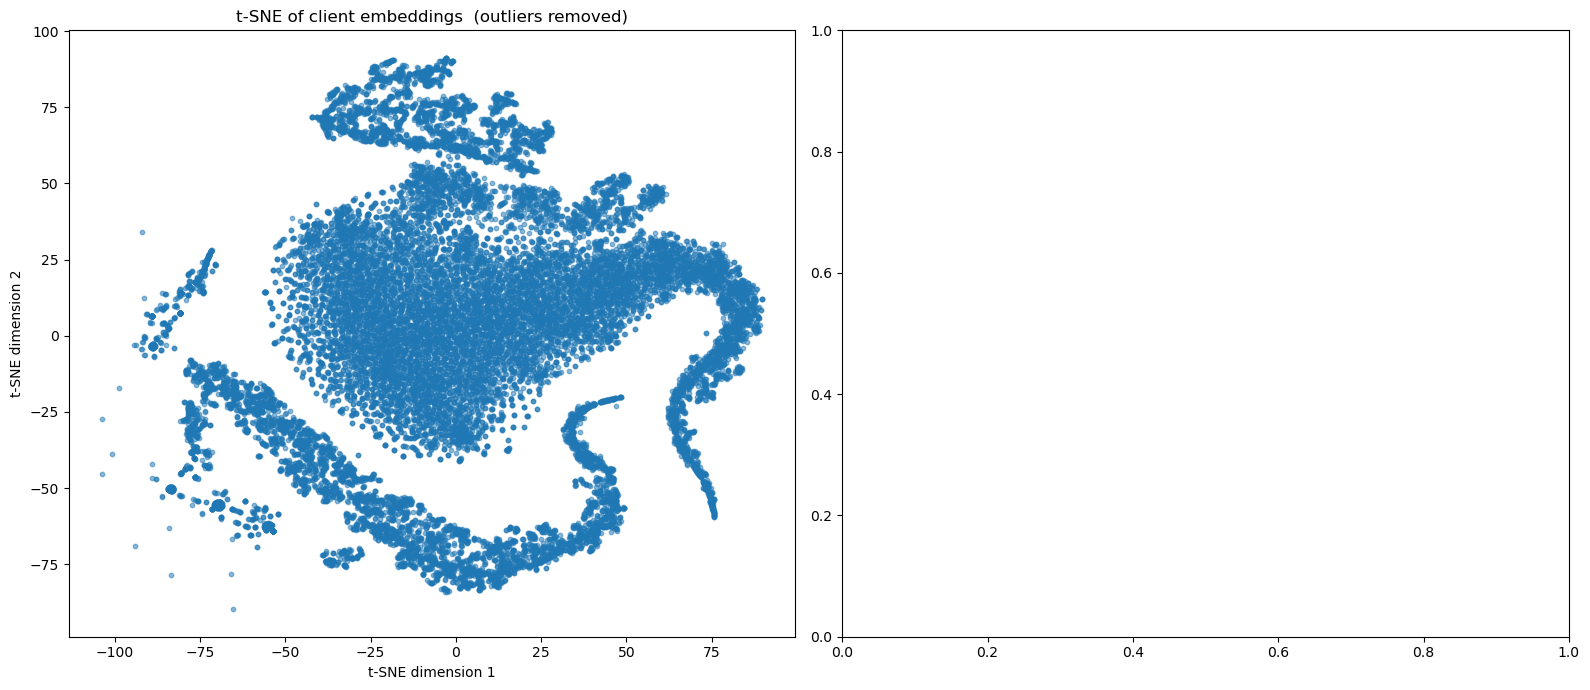

In [111]:
tsne_graph(user_emb_baseline)

In [ ]:
# np.save("./embeds_a/embeddings.npy", embeds_a.astype(np.float16))
# np.save("./embeds_a/client_ids.npy", baseline_client_ids)

In [14]:
users_np = np.array([ my_node_id_map.user_of_id[i] for i in range(my_node_id_map.n_users)], dtype=np.int64)

In [15]:
my_user_emb.shape, users_np.shape

(torch.Size([21233, 64]), (21233,))

In [28]:
! mkdir embeds_71

In [ ]:
! PYTHONPATH=$PYTHONPATH:../recsys2025 python -m training_pipeline.train --data-dir /content/drive/MyDrive/ubc_data_relevant_splitted --embeddings-dir ./embeds_a --tasks churn propensity_category propensity_sku --log-name experiment-a --accelerator gpu --devices auto --disable-relevant-clients-check

In [30]:
np.save("./embeds_71/client_ids.npy", users_np)
np.save("./embeds_71/embeddings.npy", my_user_emb.numpy().astype(np.float16))

In [19]:
### NOTE!:
### There are 2 types of ids: product has sku    and the id of a product node in graph (can exchange with node_id_map.item_of_id/id_of_item).
#                             user has client_id and the id of a user    node in graph

node_id_map = NodeIdMap(known_users, all_categories)
train_edge_index = node_id_map.make_edges(train_target_known.client_id.values, train_target_known.category.values).to(device=device)
val_edge_index = node_id_map.make_edges(valid_target_known.client_id.values, valid_target_known.category.values).to(device=device)

N = node_id_map.N

In [20]:
# TODO: take negatives from batch items, not from all
neg_samples = 5
batch_size = 16
### these are edges used for loss calculation
### and they define the graph (maybe together with product_buy, remove_from_cart)
train_loader = BprLossLoader(
    edge_index=train_edge_index,
    trg_index_range=(node_id_map.n_users, node_id_map.N), # node index range for all items (used to sample negative items)
    batch_size=batch_size,
    neg_samples=neg_samples,
    random_state=42,
    device=device
)

test_loader = BprLossLoader(
  edge_index=val_edge_index,
  trg_index_range=(node_id_map.n_users, node_id_map.N),  # node index range for all items (used to sample negative items)
  batch_size=batch_size,
  neg_samples=neg_samples,
  random_state=42,
  device=device
)

In [21]:
embedding_dim = 16
edge_dim = 3
num_layers=3
dropout_gat=0.5
init_type='normal'
init_a=0.001
dropout_edge=0.5
lr=0.001
l2_reg=0.0001
accumulate_grad_batches=10
patience=5
lr_reduce_factor=0.5
lr_scheduler_monitor="train_loss"
auroc_batch_size=256
max_epochs=50

def make_model():
  ### define graph
  # new_recgat = lambda: RecGAT(users, items, embedding_dim=embedding_dim, edge_dim=edge_dim, num_layers=2, device=device, dropout=0.3, type='uniform', a=0.0000001)
  new_recgat = lambda: RecGAT(known_users, all_categories, embedding_dim=embedding_dim, edge_dim=edge_dim, num_layers=num_layers, device=device, dropout=dropout_gat, type=init_type, a=init_a)
  recgat = new_recgat()
  
  edge_attr_add_to_cart = torch.tensor([[1, 0, 0]], dtype=torch.float).repeat(len(input_data.add_to_cart), 1).to(device)
  edge_attr_remove_from_cart = torch.tensor([[0, 1, 0]], dtype=torch.float).repeat(len(input_data.remove_from_cart), 1).to(device)
  edge_attr_product_buy = torch.tensor([[0, 0, 1]], dtype=torch.float).repeat(len(input_data.product_buy), 1).to(device)

  recgat.add_edges_from_user_category_df(input_data.add_to_cart, edge_attr=edge_attr_add_to_cart)
  recgat.add_edges_from_user_category_df(input_data.remove_from_cart, edge_attr=edge_attr_remove_from_cart)
  recgat.add_edges_from_user_category_df(input_data.product_buy, edge_attr=edge_attr_product_buy)
  
  ### edge predictor (here: only for add_to_cart edges. todo: predict more stuff (like next purchased category in next 14days from propensity categories) with more varied predictors and combine losses)
  edge_predictor = LinearEdgePredictor(embedding_dim=embedding_dim, dropout=dropout_edge).to(device=device)

  model = BprTraining(
      recgat=recgat,
      edge_predictor=edge_predictor,
      lr=lr,
      l2_reg=l2_reg,
      # propensity_sku=sampled_items, # for auroc calc
      auroc_batch_size=auroc_batch_size,
      val_edge_index=val_edge_index,
      patience=patience,
      factor=lr_reduce_factor,
      lr_scheduler_monitor=lr_scheduler_monitor,
      # forward_gat_every_n = 20, ### tradeoff : speed vs training stability
      # this has to be fixed and work with n>1, this is slow, use big batch to make up for it:
      # forward_gat_every_n = accumulate_grad_batches,
    )

  ### sillynes
  # model = remake_model_if_loss_nan(model)
  return model


In [ ]:
# md = make_model()
# md.auroc()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fd062f8ac60>>
Traceback (most recent call last):
  File "/home/zmrocze/studia/uwr/sem2/adm/projekt/.mamba/envs/my-mamba-environment/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import WandbLogger

model_checkpoint_val = ModelCheckpoint(
    monitor='val_loss',
    auto_insert_metric_name=True,
    save_top_k=2,
    mode='min',
)
model_checkpoint_auroc = ModelCheckpoint(
  monitor='val_auroc',
  auto_insert_metric_name=True,
  mode = 'max',
  save_top_k=2,
)

# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau()

# model = remake_model_if_loss_nan(make_model)
model = make_model()

log_model = True
trial_k = random.randint(0, 100000)
wandb_logger = WandbLogger(
  # project="recsys_categories",
  project="recsys2025",
  name=f"recgat_bpr_{trial_k}",
  log_model=True
  )
wandb_logger.experiment.config.update({
  "embedding_dim": embedding_dim,
  "edge_dim": edge_dim,
  "num_layers": num_layers,
  "dropout_gat": dropout_gat,
  "init_type": init_type,
  "init_a": init_a,
  "dropout_edge": dropout_edge,
  "lr": lr,
  "l2_reg": l2_reg,
  "batch_size": batch_size,
  "auroc_batch_size": auroc_batch_size,
  "accumulate_grad_batches": accumulate_grad_batches,
  "neg_samples": neg_samples,
  "log_model": log_model,
  "graph_items": model.recgat.node_id_map.n_items,
  "graph_users": model.recgat.node_id_map.n_users,
  "graph_edges_n": model.recgat.edge_index.size(1)
})

trainer = pl.Trainer(  max_epochs=max_epochs
                     , check_val_every_n_epoch=accumulate_grad_batches
                     , logger=wandb_logger
                     , callbacks=[model_checkpoint_auroc, model_checkpoint_val, ]
                     , accumulate_grad_batches=accumulate_grad_batches
                    #  , terminate_on_nan=True
                     )

# print("test_loader", test_loader)
# print("test_edges.shape", test_edges.shape)
wandb_logger.watch(model, log="all")

trainer.fit(model, train_loader, val_dataloaders=test_loader)

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: Currently logged in as: zmrocze (zmrocze-uniwroc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | recgat         | RecGAT              | 50.4 M | train
1 | edge_predictor | LinearEdgePredictor | 32.9 K | train
---------------------------------------------------------------
50.4 M    Trainable params
0         Non-trainable params
50.4 M    Total params
201.717   Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# model.lr = 0.0001